-   How can I read, inspect, and process spatial objects, such as points, lines, and polygons?

-   Load spatial objects.
-   Select the spatial objects within a bounding box.
-   Perform a CRS conversion of spatial objects.
-   Select features of spatial objects.
-   Match objects in two datasets based on their spatial relationships.

## Introduction

As discussed in [Episode 2: Introduction to Vector Data](02-intro-vector-data.md), vector data represents specific features on the Earth’s surface using points, lines, and polygons. These geographic elements can then have one or more attributes assigned to them, such as ‘name’ and ‘population’ for a city, or crop type for a field. Vector data can be much smaller in (file) size than raster data, while being very rich in terms of the information captured.

In this episode, we will be moving from working with raster data to working with vector data. We will use Python to open and plot point, line, and polygon vector data. In particular, we will make use of the [`geopandas`](https://geopandas.org/en/stable/) package to open, manipulate and write vector datasets.

<img src="attachment:fig/E07/pandas_geopandas_relation.png" alt="Pandas and Geopandas" />

`geopandas` extends the popular `pandas` library for data analysis to geospatial applications. The main `pandas` objects (the `Series` and the `DataFrame`) are expanded to `geopandas` objects (`GeoSeries` and `GeoDataFrame`). This extension is implemented by including geometric types, represented in Python using the `shapely` library, and by providing dedicated methods for spatial operations (union, intersection, etc.). The relationship between `Series`, `DataFrame`, `GeoSeries` and `GeoDataFrame` can be briefly explained as follow:

-   A `Series` is a one-dimensional array with axis, holding any data type (integers, strings, floating-point numbers, Python objects, etc.)
-   A `DataFrame` is a two-dimensional labeled data structure with columns of potentially different types1.
-   A `GeoSeries` is a `Series` object designed to store shapely geometry objects.
-   A `GeoDataFrame` is an extened `pandas.DataFrame`, which has a column with geometry objects, and this column is a `GeoSeries`.

In later episodes, we will learn how to work with raster and vector data together and combine them into a single plot.

## Introduce the Vector Data

In this episode, we will use the downloaded vector data in the `data` directory. Please refer to the [setup page](learners/setup.md#troubleshooting-conda-command-not-found) on how to download the data.

## Import Vector Datasets

In [7]:
import geopandas as gpd

Administration data retrieved from GADM. Download [link](https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_GRC_shp.zip)

In [ ]:
# p_buildings = './greece-latest-free/gis_osm_buildings_a_free_1.shp'
# p_landuse = './greece-latest-free/gis_osm_landuse_a_free_1.shp'
p_nature = './greece-latest-free/gis_osm_pofw_a_free_1.shp'

In [33]:
data = gpd.read_file('./greece-latest-free/gadm41_GRC_3.shp')

,GID_3,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,NL_NAME_2,NAME_3,VARNAME_3,NL_NAME_3,TYPE_3,ENGTYPE_3,CC_3,HASC_3,geometry
34,GRC.1.2.26_1,GRC,Greece,GRC.1_1,Aegean,Αιγαίο,GRC.1.2_1,South Aegean,Νότιο Αιγαίο,Rhodos,Rhodes,Ρόδου,Dímos,Municipality,NA,GR.AI.RH,"MULTIPOLYGON (((27.75792 35.88792, 27.75903 35..."


In [34]:
df_rhodes = data.loc[data['NAME_3']=='Rhodos']

<Axes: >

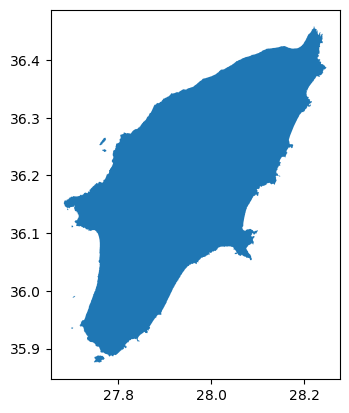

In [35]:
df_rhodes.plot()

In [30]:
data['NAME_3']=='Rhodos'

0      False
1      False
2      False
3      False
4      False
       ...  
321    False
322    False
323    False
324    False
325    False
Name: NAME_3, Length: 326, dtype: bool

In [11]:
data = gpd.read_file(geodatasets.get_url('naturalearth.land'))
data

,featurecla,scalerank,min_zoom,geometry
0,Land,1,1.0,"POLYGON ((-59.57209 -80.04018, -59.86585 -80.5..."
1,Land,1,1.0,"POLYGON ((-159.20818 -79.49706, -161.12760 -79..."
2,Land,1,0.0,"POLYGON ((-45.15476 -78.04707, -43.92083 -78.4..."
3,Land,1,1.0,"POLYGON ((-121.21151 -73.50099, -119.91885 -73..."
4,Land,1,1.0,"POLYGON ((-125.55957 -73.48135, -124.03188 -73..."
...,...,...,...,...
122,Land,1,1.0,"POLYGON ((51.13619 80.54728, 49.79368 80.41543..."
123,Land,0,0.0,"POLYGON ((99.93976 78.88094, 97.75794 78.75620..."
124,Land,0,0.0,"POLYGON ((-87.02000 79.66000, -85.81435 79.336..."
125,Land,0,0.0,"POLYGON ((-68.50000 83.10632, -65.82735 83.028..."


<Axes: >

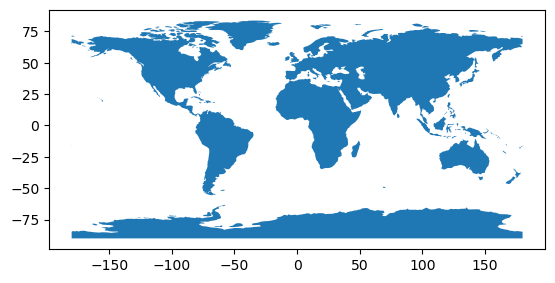

In [10]:
data.plot()

In [ ]:
gdf = gpd.read_file(p_nature)

In [ ]:
gdf_rhodes = gdf.cx[27.5:28.4, 35.8:36.5]

In [ ]:
gdf_rhodes

In [ ]:
from matplotlib import pyplot as plt
# fig, ax = plt.subplots()
gdf_rhodes.plot(column='fclass', legend=True, legend_kwds={'loc': 'right'})
# plt.colorbar(ax)


In [ ]:
landuse_rhodes

We will use the `geopandas` package to load the crop field vector data we downloaded at: `data/brpgewaspercelen_definitief_2020_small.gpkg`.

In [ ]:
fields = gpd.read_file("data/brpgewaspercelen_definitief_2020_small.gpkg")
fields

The data are read into the variable `fields` as a `GeoDataFrame`. This is an extened data format of `pandas.DataFrame`, with an extra column `geometry`.

This file contains a relatively large number of crop field parcels. Directly loading a large file to memory can be slow. If the Area of Interest (AoI) is small, we can define a bounding box of the AoI, and only read the data within the extent of the bounding box.

In [ ]:
# Define bounding box
xmin, xmax = (110_000, 140_000)
ymin, ymax = (470_000, 510_000)
bbox = (xmin, ymin, xmax, ymax)

Using the `bbox` input argument, we can load only the spatial features intersecting the provided bounding box.

In [ ]:
# Partially load data within the bounding box
fields = gpd.read_file("data/brpgewaspercelen_definitief_2020_small.gpkg", bbox=bbox)

## How should I define my bounding box?

For simplicity, here we assume the **Coordinate Reference System (CRS)** and **extent** of the vector file are known (for instance they are provided in the dataset documentation).

You can also define your bounding box with online coordinates visualization tools. For example, we can use the “Draw Rectangular Polygon” tool in [geojson.io](https://geojson.io/#map=8.62/52.45/4.96).

Some Python tools, e.g. [`fiona`](https://fiona.readthedocs.io/en/latest/)(which is also the backend of `geopandas`), provide the file inspection functionality without the need to read the full data set into memory. An example can be found in [the documentation of fiona](https://fiona.readthedocs.io/en/latest/manual.html#format-drivers-crs-bounds-and-schema).

And we can plot the overview by:

In [ ]:
fields.plot()

<img src="attachment:fig/E07/fields.png" alt="Crop fields inside the AOI" />

## Vector Metadata & Attributes

When we read the vector dataset with Python (as our `fields` variable) it is loaded as a `GeoDataFrame` object. The `read_file()` function also automatically stores geospatial information about the data. We are particularly interested in describing the format, CRS, extent, and other components of the vector data, and the attributes which describe properties associated
with each vector object.

We will explore

1.  **Object Type:** the class of the imported object.
2.  **Coordinate Reference System (CRS):** the projection of the data.
3.  **Extent:** the spatial extent (i.e. geographic area that the data covers). Note that the spatial extent for a vector dataset represents the combined extent for all spatial objects in the dataset.

Each `GeoDataFrame` has a `"geometry"` column that contains geometries. In the case of our `fields` object, this geometry is represented by a `shapely.geometry.Polygon` object. `geopandas` uses the `shapely` library to represent polygons, lines, and points, so the types are inherited from `shapely`.

We can view the metadata using the `.crs`, `.bounds` and `.type` attributes. First, let’s view the
geometry type for our crop field dataset. To view the geometry type, we use the `pandas` method `.type` on the `GeoDataFrame` object, `fields`.

In [ ]:
fields.type

``` output
0        Polygon
1        Polygon
2        Polygon
3        Polygon
4        Polygon
          ...
22026    Polygon
22027    Polygon
22028    Polygon
22029    Polygon
22030    Polygon
Length: 22031, dtype: object
```

To view the CRS metadata:

In [ ]:
fields.crs

``` output
<Derived Projected CRS: EPSG:28992>
Name: Amersfoort / RD New
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Netherlands - onshore, including Waddenzee, Dutch Wadden Islands and 12-mile offshore coastal zone.
- bounds: (3.2, 50.75, 7.22, 53.7)
Coordinate Operation:
- name: RD New
- method: Oblique Stereographic
Datum: Amersfoort
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich
```

Our data is in the CRS **RD New**. The CRS is critical to
interpreting the object’s extent values as it specifies units. To find
the extent of our dataset in the projected coordinates, we can use the `.total_bounds` attribute:

In [ ]:
fields.total_bounds

``` output
array([109222.03325 , 469461.512625, 140295.122125, 510939.997875])
```

This array contains, in order, the values for minx, miny, maxx and maxy, for the overall dataset. The spatial extent of a GeoDataFrame represents the geographic “edge” or location that is the furthest north, south, east, and west. Thus, it represents the overall geographic coverage of the spatial object.

We can convert these coordinates to a bounding box or acquire the index of the Dataframe to access the geometry. Either of these polygons can be used to clip rasters (more on that later).

## Further crop the dataset

We might realize that the loaded dataset is still too large. If we want to refine our area of interest to an even smaller extent, without reloading the data, we can use the [`cx`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.cx.html) indexer:

In [ ]:
# A smaller bounding box in RD
xmin, xmax = (120_000, 135_000)
ymin, ymax = (485_000, 500_000)

fields_cx = fields.cx[xmin:xmax, ymin:ymax]

## Export data to file

We will save the cropped results to a shapefile (`.shp`) and use it later. The `to_file` function can be used for exportation:

In [ ]:
fields_cx.to_file('fields_cropped.shp')

This will write it to disk (in this case, in ‘shapefile’ format), containing only the data from our cropped area. It can be read again at a later time using the `read_file()` method we have been using above. Note that this actually writes multiple files to disk (`fields_cropped.cpg`, `fields_cropped.dbf`, `fields_cropped.prj`, `fields_cropped.shp`, `fields_cropped.shx`). All these files should ideally be present in order to re-read the dataset later, although only the `.shp`, `.shx`, and `.dbf` files are mandatory (see the [Introduction to Vector Data](02-intro-vector-data.md) lesson for more information.)

## Selecting spatial features

From now on, we will take in a point dataset `brogmwvolledigeset.zip`, which is the underground water monitoring wells. We will perform vector processing on this dataset, together with the cropped field polygons `fields_cropped.shp`.

Let’s read the two datasets.

In [ ]:
fields = gpd.read_file("fields_cropped.shp")
wells = gpd.read_file("data/brogmwvolledigeset.zip")

And take a look at the wells:

In [ ]:
wells.plot(markersize=0.1)

<img src="attachment:fig/E07/wells-nl.png" alt="all wells in the NL" />

The points represents all the wells over the Netherlands. Since the wells are in the lat/lon coordinates. To make it comparable with fields, we need to first transfer the CRS to the “RD New” projection:

In [ ]:
wells = wells.to_crs(epsg=28992)

Now we would like to compare the wells with the cropped fields. We can select the wells within the fields using the `.clip` function:

In [ ]:
wells_clip = wells.clip(fields)
wells_clip

``` output
bro_id delivery_accountable_party quality_regime  ...
40744  GMW000000043703  27364178    IMBRO/A    ...
38728  GMW000000045818  27364178    IMBRO/A    ...
...                ...       ...        ...    ...
40174  GMW000000043963  27364178    IMBRO/A    ...
19445  GMW000000024992  50200097    IMBRO/A    ...
[79 rows x 40 columns]
```

After this selection, all the wells outside the fields are dropped. This takes a while to execute, because we are clipping a relatively large number of points with many polygons.

If we do not want a precise clipping, but rather have the points in the neighborhood of the fields, we will need to create another polygon, which is slightly bigger than the coverage of the field. To do this, we can increase the size of the field polygons, to make them overlap with each other, and then merge the overlapping polygons together.

We will first use the `buffer` function to increase field size with a given `distance`. The unit of the `distance` argument is the same as the CRS. Here we use a 50-meter buffer. Also notice that the `.buffer` function produces a `GeoSeries`, so to keep the other columns, we assign it to the `GeoDataFrame` as a geometry column.

In [ ]:
buffer = fields.buffer(50)
fields_buffer = fields.copy()
fields_buffer['geometry'] = buffer
fields_buffer.plot()

<img src="attachment:fig/E07/fields-buffer.png" alt="50m buffer around the fields" />

To further simplify them, we can use the `dissolve` function to dissolve the buffers into one:

In [ ]:
fields_buffer_dissolve = fields_buffer.dissolve()
fields_buffer_dissolve

All the fields will be dissolved into one multi-polygon, which can be used to `clip` the wells.

In [ ]:
wells_clip_buffer = wells.clip(fields_buffer_dissolve)
wells_clip_buffer.plot()

<img src="attachment:fig/E07/wells-in-buffer.png" alt="Wells within 50m buffer of fields" />

In this way, we selected all wells within the 50m range of the fields. It is also significantly faster than the previous `clip` operation, since the number of polygons is much smaller after `dissolve`.

## Exercise: clip fields within 500m from the wells

This time, we will do a selection the other way around. Can you clip the field polygons (stored in fields_cropped.shp) with the 500m buffer of the wells (stored in brogmwvolledigeset.zip)? Please visualize the results.

-   Hint 1: The file `brogmwvolledigeset.zip` is in CRS 4326. Don’t forget the CRS conversion.

-   Hint 2: `brogmwvolledigeset.zip` contains all the wells in the Netherlands, which means it might be too big for the `.buffer()` function. To improve the performance, first crop it with the bounding box of the fields.

In [ ]:
# Read in data
fields =  gpd.read_file("fields_cropped.shp")
wells = gpd.read_file("data/brogmwvolledigeset.zip")

# Crop points with bounding box
xmin, ymin, xmax, ymax = fields.total_bounds
wells = wells.to_crs(28992)
wells_cx = wells.cx[xmin-500:xmax+500, ymin-500:ymax+500]

# Create buffer
wells_cx_500mbuffer = wells_cx.copy()
wells_cx_500mbuffer['geometry'] = wells_cx.buffer(500)

# Clip
fields_clip_buffer = fields.clip(wells_cx_500mbuffer)
fields_clip_buffer.plot()

<img src="attachment:fig/E07/fields-in-buffer-clip.png" alt="fields within 50m buffer of the wells, truncated" />

## Spatially join the features

In the exercise, we clipped the fields polygons with the 500m buffers of wells. The results from this clipping changed the shape of the polygons. If we would like to keep the original shape of the fields, one way is to use the `sjoin` function, which join two `GeoDataFrame`’s on the basis of their spatial relationship:

In [ ]:
# Join fields and wells_cx_500mbuffer
fields_wells_buffer = fields.sjoin(wells_cx_500mbuffer)
print(fields_wells_buffer.shape)

``` output
(11420, 46)
```

This will result in a `GeodataFrame` of all possible combinations of polygons and well buffers intersecting each other. Since a polygon can fall into multiple buffers, there will be duplicated field indexes in the results. To select the fields which intersects the well buffers, we can first get the unique indexes, and use the `iloc` indexer to select:

In [ ]:
idx = fields_wells_buffer.index.unique()
fiedls_in_buffer = fields.iloc[idx]

fiedls_in_buffer.plot()

<img src="attachment:fig/E07/fields-in-buffer-sjoin.png" alt="Fields in 50m buffer of wells, not truncated" />

## Modify the geometry of a GeoDataFrame

## Exercise: Investigate the waterway lines

Now we will take a deeper look at the Dutch waterway lines: `waterways_nl`. Let’s load the file `status_vaarweg.zip`, and visualize it with the `plot()` function. Can you tell what is wrong with this vector file?

By plotting out the vector file, we can tell that the latitude and longitude of the file are flipped.

In [ ]:
waterways_nl = gpd.read_file('data/status_vaarweg.zip')
waterways_nl.plot()

<img src="attachment:fig/E07/waterways-wrong.png" alt="waterways, rotated" />

## Axis ordering

According to the standards, the axis ordering for a CRS should follow the definition provided by the competent authority. For the commonly used EPSG:4326 geographic coordinate system, the EPSG defines the ordering as first latitude then longitude.
However, in the GIS world, it is custom to work with coordinate tuples where the first component is aligned with the east/west direction and the second component is aligned with the north/south direction.
Multiple software packages thus implement this convention also when dealing with EPSG:4326.
As a result, one can encounter vector files that implement either convention - keep this in mind and always check your datasets!

Sometimes we need to modify the `geometry` of a `GeoDataFrame`. For example, as we have seen in the previous exercise **Investigate the waterway lines**, the latitude and longitude are flipped in the vector data `waterways_nl`. This error needs to be fixed before performing further analysis.

Let’s first take a look on what makes up the `geometry` column of `waterways_nl`:

In [ ]:
waterways_nl['geometry']

``` output
0     LINESTRING (52.41810 4.84060, 52.42070 4.84090...
1     LINESTRING (52.11910 4.67450, 52.11930 4.67340...
2     LINESTRING (52.10090 4.25730, 52.10390 4.25530...
3     LINESTRING (53.47250 6.84550, 53.47740 6.83840...
4     LINESTRING (52.32270 5.14300, 52.32100 5.14640...
                            ...
86    LINESTRING (51.49270 5.39100, 51.48050 5.39160...
87    LINESTRING (52.15900 5.38510, 52.16010 5.38340...
88    LINESTRING (51.97340 4.12420, 51.97110 4.12220...
89    LINESTRING (52.11910 4.67450, 52.11850 4.67430...
90    LINESTRING (51.88940 4.61900, 51.89040 4.61350...
Name: geometry, Length: 91, dtype: geometry
```

Each row is a `LINESTRING` object. We can further zoom into one of the rows, for example, the third row:

In [ ]:
print(waterways_nl['geometry'][2])
print(type(waterways_nl['geometry'][2]))

``` output
LINESTRING (52.100900002 4.25730000099998, 52.1039 4.25529999999998, 52.111299999 4.24929999900002, 52.1274 4.23449999799999)
<class 'shapely.geometry.linestring.LineString'>
```

As we can see in the output, the `LINESTRING` object contains a list of coordinates of the vertices. In our situation, we would like to find a way to flip the x and y of every coordinates set. A good way to look for the solution is to use the [documentation](https://shapely.readthedocs.io/en/stable/manual.html) of the `shapely` package, since we are seeking to modify the `LINESTRING` object. Here we are going to use the [`shapely.ops.transform`](https://shapely.readthedocs.io/en/stable/manual.html?highlight=shapely.ops.transform#shapely.ops.transform) function, which applies a self-defined function to all coordinates of a geometry.

In [ ]:
import shapely

# Define a function flipping the x and y coordinate values
def flip(geometry):
    return shapely.ops.transform(lambda x, y: (y, x), geometry)

# Apply this function to all coordinates and all lines
geom_corrected = waterways_nl['geometry'].apply(flip)

Then we can update the `geometry` column with the corrected geometry `geom_corrected`, and visualize it to check:

In [ ]:
# Update geometry
waterways_nl['geometry'] = geom_corrected

# Visualization
waterways_nl.plot()

<img src="attachment:fig/E07/waterways-corrected.png" alt="waterways, corrected" />

Now the waterways look good! We can save the vector data for later usage:

In [ ]:
# Update geometry
waterways_nl.to_file('waterways_nl_corrected.shp')

-   Load spatial objects into Python with `geopandas.read_file()` function.
-   Spatial objects can be plotted directly with `GeoDataFrame`’s `.plot()` method.
-   Crop spatial objects with `.cx[]` indexer.
-   Convert CRS of spatial objects with `.to_crs()`.
-   Select spatial features with `.clip()`.
-   Create a buffer of spatial objects with `.buffer()`.
-   Merge overlapping spatial objects with `.dissolve()`.
-   Join spatial features spatially with `.sjoin()`.